In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

In [2]:
root_dir = "/unix/erw/soil_model_9-7-25/build/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
print(element_list)
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        spectrum = file["Edep (noise)"].values()
        #spectrum = file["Edep"].values()
        total_counts = np.sum(spectrum)
        spectrum = spectrum / total_counts # Normalize
        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()           # Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)  # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))               # shape: [N, num_elements]

# Check data
i = 0  

print("\nX shape:", X.shape) 
print(f"X[{i}][:20] values:\n", X[i][0][:20]) 

print("\nY shape:", Y.shape) 
print(f"Y[{i}] values:\n", Y[i])

print("\nElement：")
for idx, frac in enumerate(Y[i]):
    print(f"{element_list[idx]}: {frac.item():.4f}")

['C', 'O', 'Si']

X shape: torch.Size([1010, 1, 1440])
X[0][:20] values:
 tensor([0.0065, 0.0061, 0.0061, 0.0061, 0.0063, 0.0059, 0.0060, 0.0057, 0.0055,
        0.0054, 0.0055, 0.0053, 0.0054, 0.0047, 0.0047, 0.0050, 0.0049, 0.0048,
        0.0047, 0.0047])

Y shape: torch.Size([1010, 3])
Y[0] values:
 tensor([0.0000, 0.5326, 0.4674])

Element：
C: 0.0000
O: 0.5326
Si: 0.4674


In [3]:
class CNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),   # [B, 32, 1440]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 32, 720]

            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # [B, 64, 720]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # updated based on final feature map

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_outputs)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)  # normalize


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),   # [B, 32, 1440]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 32, 720]

            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # [B, 64, 720]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180 + 1  # 加上 total_counts 的 1 个特征

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_outputs)
        )

    def forward(self, x, total_counts):
        """
        Parameters
        ----------
        x : Tensor, shape [B, 1, 1440]
            Normalized spectrum input.

        total_counts : Tensor, shape [B, 1]
            Raw total counts for each sample.

        Returns
        -------
        probs : Tensor, shape [B, num_outputs]
            Softmax-normalized element composition prediction.
        """
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten to [B, 128*180]
        x = torch.cat([x, total_counts], dim=1)  # Concatenate along feature dim
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)


In [18]:
# Hyperparameter (grid search in future)
batch_size = 64
epochs = 10
learning_rate = 1e-4

In [19]:
# Split dataset
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [20]:
# Initialization
model = CNN(num_outputs=Y.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()                           # (?)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 1, 1440))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 3]                   --
├─Sequential: 1-1                        [64, 128, 180]            --
│    └─Conv1d: 2-1                       [64, 32, 1440]            192
│    └─BatchNorm1d: 2-2                  [64, 32, 1440]            64
│    └─ReLU: 2-3                         [64, 32, 1440]            --
│    └─MaxPool1d: 2-4                    [64, 32, 720]             --
│    └─Conv1d: 2-5                       [64, 64, 720]             6,208
│    └─BatchNorm1d: 2-6                  [64, 64, 720]             128
│    └─ReLU: 2-7                         [64, 64, 720]             --
│    └─MaxPool1d: 2-8                    [64, 64, 360]             --
│    └─Conv1d: 2-9                       [64, 128, 360]            24,704
│    └─BatchNorm1d: 2-10                 [64, 128, 360]            256
│    └─ReLU: 2-11                        [64, 128, 360]            --
│    

Epoch 1/10 | Train Loss: 0.0232 | Val Loss: 0.0509
Epoch 2/10 | Train Loss: 0.0048 | Val Loss: 0.0456
Epoch 3/10 | Train Loss: 0.0034 | Val Loss: 0.0449
Epoch 4/10 | Train Loss: 0.0027 | Val Loss: 0.0454
Epoch 5/10 | Train Loss: 0.0025 | Val Loss: 0.0429
Epoch 6/10 | Train Loss: 0.0022 | Val Loss: 0.0440
Epoch 7/10 | Train Loss: 0.0018 | Val Loss: 0.0278
Epoch 8/10 | Train Loss: 0.0019 | Val Loss: 0.0136
Epoch 9/10 | Train Loss: 0.0016 | Val Loss: 0.0085
Epoch 10/10 | Train Loss: 0.0016 | Val Loss: 0.0009


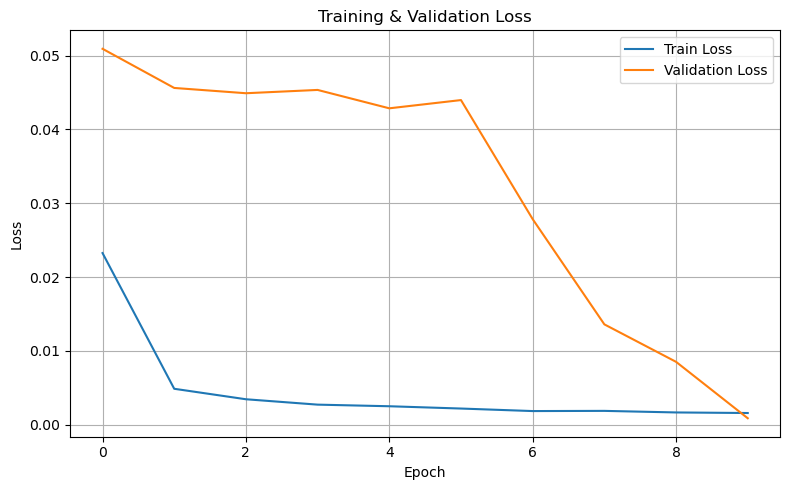

In [21]:
# Train the model
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X) 
        loss = criterion(preds, batch_Y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            preds = model(val_X)
            loss = criterion(preds, val_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

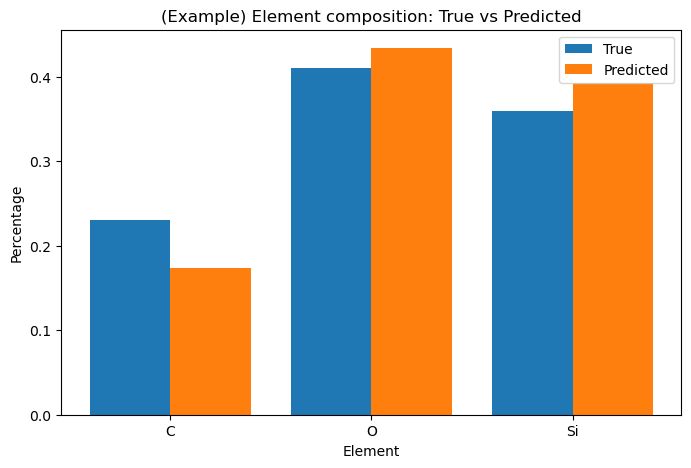

In [22]:
model.eval()

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)

        # take one sample
        preds = model(val_X)            # [B, num_elements]
        pred_probs = preds[0].cpu()
        true_probs = val_Y[0].cpu()

        # plot
        x = torch.arange(len(true_probs))
        element_names = element_list

        plt.figure(figsize=(8, 5))
        plt.bar(x - 0.2, true_probs, width=0.4, label='True')
        plt.bar(x + 0.2, pred_probs, width=0.4, label='Predicted')
        plt.xlabel("Element")
        plt.ylabel("Percentage")
        plt.title("(Example) Element composition: True vs Predicted")
        plt.xticks(x, element_names)
        plt.legend()
        plt.show()
        break  # just show one example

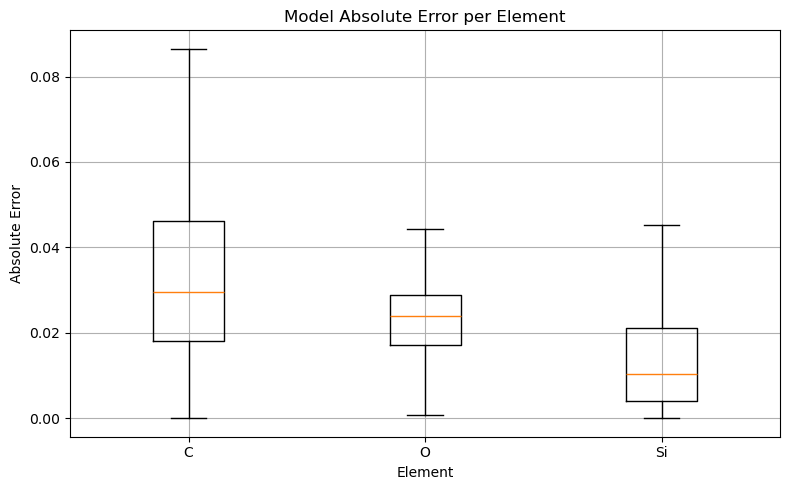

In [23]:
model.eval()

abs_errors = []

all_true = []
all_pred = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)
        preds = model(val_X)
        preds = preds.cpu()
        val_Y = val_Y.cpu()

        all_true.append(val_Y)
        all_pred.append(preds)


true_all = torch.cat(all_true, dim=0)
pred_all = torch.cat(all_pred, dim=0)

abs_errors = torch.abs(pred_all - true_all).numpy()  # shape: [N, num_elements]

# boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(abs_errors, tick_labels=element_list, showfliers=False)
plt.ylabel("Absolute Error")
plt.xlabel("Element")
plt.title("Boxplot of Absolute Error per Element")
plt.grid(True)
plt.tight_layout()
plt.show()


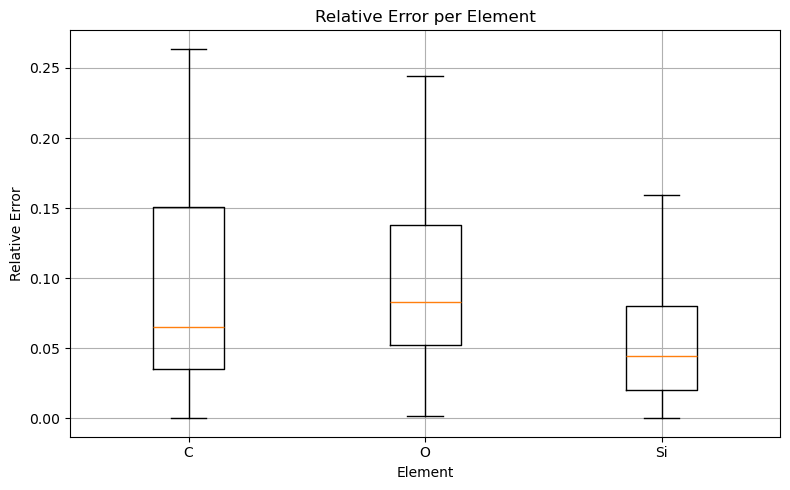

In [28]:
model.eval()
epsilon = 1e-4  # avoid 0
all_rel_errors = []  

num_elements = Y.shape[1]
all_rel_errors = [[] for _ in range(num_elements)]

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)
        preds = model(val_X)

        abs_diff = torch.abs(preds - val_Y)
        rel_error = abs_diff / (val_Y + epsilon)

        for i in range(len(val_Y)):   # each sample
            for j in range(num_elements):  # each element
                all_rel_errors[j].append(rel_error[i, j].item())

# plot
plt.figure(figsize=(8, 5))
plt.boxplot(all_rel_errors, tick_labels=element_list, showfliers=False)
plt.ylabel("Relative Error")
plt.xlabel("Element")
plt.title("Relative Error per Element")
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()
